# Quantum Fourier transform circuit

This program simulates Quantum Fourier transform using qiskit. It explains basic principles and gives some explicite examples. \
Author: Ema Žánová \
Time: 08.13.2025 \
Note: Ensure you have installed the requirements.txt or environment.yml before running this notebook.

## 1.1 Introduction

The Quantum Fourier Transform is the quantum analog of the classical Discrete Fourier Transform (DFT) and represents one of the most fundamental quantum algorithms. It serves as a crucial subroutine in many quantum algorithms, including Shor's factoring algorithm and quantum phase estimation.

## 1.2 Basic Principles

The QFT performs a unitary transformation on a quantum state, converting between the computational basis and the Fourier basis. Unlike the classical DFT which operates on classical data, the QFT operates on quantum superposition states, leveraging quantum parallelism to achieve exponential speedup for certain problems.

### Key Characteristics:
- **Reversible**: Being a unitary transformation, the QFT is completely reversible
- **Exponential speedup**: Processes all $2^n$ amplitudes simultaneously through superposition
- **Basis transformation**: Maps computational basis states to Fourier basis states
- **Periodic structure**: Exploits periodicity in quantum states for algorithmic advantages

## 1.3 Mathematical Formulation

### 1.3.1 Discrete Fourier Transform (Classical)
For reference, the classical DFT on $N = 2^n$ points is defined as:

$$y_k = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} x_j \omega_N^{jk}$$

where $\omega_N = e^{2\pi i/N}$ is the primitive $N$-th root of unity.

### 1.3.2 Quantum Fourier Transform
The QFT performs the following transformation on computational basis states:

$$\text{QFT}|j\rangle = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \omega_{2^n}^{jk} |k\rangle$$

where:
- $|j\rangle$ represents a computational basis state
- $n$ is the number of qubits
- $\omega_{2^n} = e^{2\pi i/2^n}$ is the primitive $2^n$-th root of unity


## 1.4 Complexity Comparison

| Transform | Classical DFT | Quantum FT |
|-----------|---------------|------------|
| **Time Complexity** | $O(N \log N)$ | $O((\log N)^2)$ |
| **Space Complexity** | $O(N)$ | $O(\log N)$ qubits |
| **Data Points** | $N$ classical values | $2^n$ quantum amplitudes |

The exponential advantage comes from quantum superposition allowing simultaneous processing of all $2^n$ amplitudes with only $n$ qubits.

---

*This notebook will explore the implementation, circuit design, and applications of the Quantum Fourier Transform in detail.*

## 2. QFT code implementation
QFT also exist in qiskit as a block, which you can implement. But to uderstand it better, we are going to write it by ourselfs. 

In [26]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from math import pi, log2

def myQFT(n_qubits):
    circuit = QuantumCircuit(n_qubits)

    for j in range(n_qubits//2):
        circuit.swap(j, n_qubits-j-1)
    
    circuit.barrier()
    
    for i in range(n_qubits):
        circuit.h(i)
        for j in range(1, n_qubits - i):
            circuit.cp(pi / 2**j, i + j, i)  # 
    
    return circuit

# 3. Why SWAP Gates Matter in QFT Implementation

## 3.1 The Bit Reversal Problem

When implementing the Quantum Fourier Transform, you'll notice that the **order of qubits matters critically**. This is due to an inherent property of the QFT algorithm: it naturally produces results in **bit-reversed order**.

### 3.2 What Happens Without SWAP Gates

The standard QFT circuit (without SWAP gates) transforms:
$$|j\rangle \rightarrow \frac{1}{2^{n/2}} \bigotimes_{l=0}^{n-1} \left(|0\rangle + e^{2\pi i \cdot 0.j_l j_{l-1} \ldots j_0} |1\rangle\right)$$

However, due to the way quantum circuits are constructed, the output qubits are in **reverse order** compared to what we typically expect.

### 3.3 Example: 3-Qubit QFT

For a 3-qubit system with input state $|j_2 j_1 j_0\rangle$:

**Without SWAP gates (bit-reversed output):**
- Qubit 0 (top wire) contains: $\frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i \cdot 0.j_2 j_1 j_0}|1\rangle)$
- Qubit 1 (middle wire) contains: $\frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i \cdot 0.j_1 j_0}|1\rangle)$  
- Qubit 2 (bottom wire) contains: $\frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i \cdot 0.j_0}|1\rangle)$

**With SWAP gates (correct order):**
- Qubit 0 contains: $\frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i \cdot 0.j_0}|1\rangle)$
- Qubit 1 contains: $\frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i \cdot 0.j_1 j_0}|1\rangle)$
- Qubit 2 contains: $\frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i \cdot 0.j_2 j_1 j_0}|1\rangle)$

## 3.4  Why This Happens

The bit reversal occurs because:

1. **Circuit Construction**: In the standard QFT circuit, we apply rotations in a specific order that naturally reverses the bit positions.

2. **Hadamard and Rotation Pattern**: Each qubit gets a Hadamard gate followed by controlled rotations from all subsequent qubits. This creates the reversed pattern.

3. **Tensor Product Ordering**: The mathematical tensor product structure $\bigotimes_{l=0}^{n-1}$ creates this reversal when mapped to physical qubits.

## 3.5 When SWAP Gates Are Applied

### 3.5.1 SWAP at the Beginning
If you apply SWAP gates **before** the QFT:
- You're changing the **input** state
- The QFT operates on a different input than intended
- Results will be completely different because you've transformed a different state

### 3.5.2 SWAP at the End  
If you apply SWAP gates **after** the QFT:
- You're correcting the **bit-reversed output**
- This gives you the "standard" QFT result
- This is the **correct** approach for most applications

# 4. QFT SWAP Gate Placement: Quick Guide
## 4.1 Common Scenarios

### 4.1.1. Using Qiskit with `initialize()`
```python
# Qiskit's initialize() uses LITTLE-ENDIAN
qc.initialize(amplitudes, qubits)  # a[0]→|000⟩, a[1]→|001⟩, a[2]→|010⟩

# Standard QFT expects BIG-ENDIAN
# Solution: SWAP at the BEGINNING
for j in range(n_qubits//2):
    circuit.swap(j, n_qubits-j-1)
```

### 4.1.2. Manual State Preparation (Big-Endian)
```python
# If you manually prepare states in big-endian format
# where qubit 0 = MSB, qubit n-1 = LSB
# Solution: SWAP at the END (or no SWAP)
# Apply QFT, then:
for j in range(n_qubits//2):
    circuit.swap(j, n_qubits-j-1)
```

### 4.1.3. Working with Classical FFT Results
```python
# If comparing with numpy.fft.fft() output
# Most classical libraries use standard indexing
# Solution: SWAP at the END
```

## 4.2. Why Qubit 0 is Most Significant in Standard QFT

### 4.2.1. Mathematical Convention
In quantum computing textbooks, the standard tensor product notation is:
$$|q_0\rangle \otimes |q_1\rangle \otimes \ldots \otimes |q_{n-1}\rangle$$

Where:
- **q₀** = Most Significant Bit (MSB)
- **qₙ₋₁** = Least Significant Bit (LSB)

### 4.2.2. Binary Representation Example (3 qubits)
```
State |q₀q₁q₂⟩:
|000⟩ = 0×4 + 0×2 + 0×1 = 0
|001⟩ = 0×4 + 0×2 + 1×1 = 1  
|010⟩ = 0×4 + 1×2 + 0×1 = 2
|011⟩ = 0×4 + 1×2 + 1×1 = 3
|100⟩ = 1×4 + 0×2 + 0×1 = 4  ← q₀ contributes 4 (highest value)
|101⟩ = 1×4 + 0×2 + 1×1 = 5
|110⟩ = 1×4 + 1×2 + 0×1 = 6
|111⟩ = 1×4 + 1×2 + 1×1 = 7
```

### 4.2.3.QFT Circuit Structure
The QFT circuit applies rotations based on this hierarchy:
- **Qubit 0** gets rotations from ALL other qubits (most connections)
- **Qubit 1** gets rotations from qubits 2,3,... (fewer connections)  
- **Last qubit** gets only a Hadamard (no controlled rotations)

This structure inherently assumes qubit 0 = MSB.

## 4.3. Qiskit's Different Convention

### 4.3.1. Why Qiskit Uses Little-Endian
Qiskit's `initialize()` maps arrays to states as:
```python
amplitudes[0] → |000⟩  # Index 0 → Binary 000
amplitudes[1] → |001⟩  # Index 1 → Binary 001  
amplitudes[2] → |010⟩  # Index 2 → Binary 010
```

This treats **qubit n-1 as MSB**, which is **opposite** to textbook convention!

### 4.3.2. The Mismatch
```
Qiskit initialize():     |q₂q₁q₀⟩ (q₂ = MSB)
Standard QFT assumes:    |q₀q₁q₂⟩ (q₀ = MSB)
```

**Solution**: SWAP gates at the beginning convert Qiskit's little-endian to QFT's big-endian.

## 4.3.3. Decision Flowchart

```
Are you using Qiskit's initialize()?
├── YES → SWAP at BEGINNING
└── NO → Are you comparing with classical FFT?
    ├── YES → SWAP at END  
    └── NO → Check your input encoding convention
```

# Key Takeaway

**There's no universal "right" place for SWAP gates.** The correct placement depends entirely on matching your **input data convention** with your **QFT implementation convention**. Your specific case (SWAP at beginning) is the correct solution for Qiskit's initialize() function.

- **SWAP gates at the end**: Standard practice to get conventional QFT output
- **SWAP gates at the beginning**: Changes your input state entirely  
- **No SWAP gates**: Valid but requires careful handling of bit-reversed indexing
- **Both locations**: Generally unnecessary and may introduce errors

The choice depends on your specific application, but for most quantum algorithms expecting standard QFT behavior, SWAP gates should be applied **at the end** of the QFT circuit.

# 5. Step-by-Step Analysis of Your QFT Code

## 5.1. QFT Circuit Implementation

```python
def myQFT(n_qubits):
    circuit = QuantumCircuit(n_qubits)
    # SWAP gates at the beginning
    for j in range(n_qubits//2):
        circuit.swap(j, n_qubits-j-1)
    circuit.barrier()
    # Main QFT operations
    for i in range(n_qubits):
        circuit.h(i)  # Hadamard on qubit i
        for j in range(1, n_qubits - i):
            circuit.cp(pi / 2**j, i + j, i)  # Controlled phase rotations
    return circuit
```
(Just a little code recap, so you don't have to scroll all the way up :))

**What happens:**
- **SWAP gates** convert from Qiskit's little-endian to QFT's big-endian convention
- **Hadamard gates** create superposition on each qubit
- **Controlled phase gates** apply the Fourier transform rotations
- Each qubit i gets phase rotations controlled by qubits i+1, i+2, ..., n-1

## 5.2. Signal Generation
**What happens:**
- Creates a composite signal with **two frequency components**:
  - **Frequency 2**: Cosine wave with amplitude 0.4, completes 2 full cycles over N=32 samples
  - **Frequency 3**: Sine wave with amplitude 0.8, completes 3 full cycles over N=32 samples
- This is a classic test signal for Fourier analysis
(The composite function is just a randomly created functio)

In [27]:
import numpy as np

N = 32
x = np.arange(N)
f = 0.4*np.cos(2*np.pi*2*x/N) + 0.8 * np.sin(2*np.pi*3*x/N)

## 5.3. Normalization and Quantum State Preparation
**What happens:**
- **Normalization** ensures the amplitudes satisfy the quantum constraint: $\sum_i |a_i|^2 = 1$
- **State initialization** creates the quantum superposition: $|\psi\rangle = \sum_{i=0}^{31} a_i |i\rangle$
- Your 32 classical samples become amplitudes of 32 basis states |00000⟩ through |11111⟩

In [28]:
print("Signal values before normalization:", f, end="\n\n")
a = f / np.linalg.norm(f)  # normalized amplitudes
print("Normalized amplitudes:", a)
n_qubits = int(log2(N) ) # number of qubits needed to represent N
qc = QuantumCircuit(n_qubits)  
qc.initialize(a, list(range(n_qubits)))

Signal values before normalization: [ 0.4         0.814008    1.02194634  0.9377016   0.56568542  0.00299888
 -0.58898946 -1.0347275  -1.2        -1.0347275  -0.58898946  0.00299888
  0.56568542  0.9377016   1.02194634  0.814008    0.4        -0.07490437
 -0.45626091 -0.63155485 -0.56568542 -0.30914563  0.02330403  0.29562388
  0.4         0.29562388  0.02330403 -0.30914563 -0.56568542 -0.63155485
 -0.45626091 -0.07490437]

Normalized amplitudes: [ 0.1118034   0.22752215  0.28564269  0.26209556  0.15811388  0.00083821
 -0.16462756 -0.28921513 -0.3354102  -0.28921513 -0.16462756  0.00083821
  0.15811388  0.26209556  0.28564269  0.22752215  0.1118034  -0.02093641
 -0.1275288  -0.17652495 -0.15811388 -0.08640883  0.00651368  0.08262939
  0.1118034   0.08262939  0.00651368 -0.08640883 -0.15811388 -0.17652495
 -0.1275288  -0.02093641]


Let's vizualize the signal values of the function:

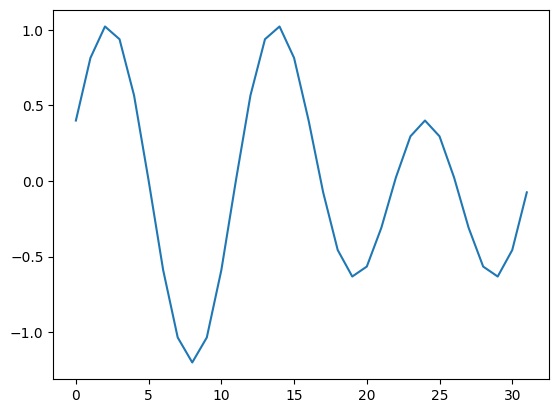

In [29]:
import matplotlib.pyplot as plt
plt.plot(x, f, label='f(x)')

## 5.4. Quantum Circuit Assembly and Execution
**What happens:**
- **Compose** adds your QFT circuit to the initialized state
- **Measure_all** adds measurement gates to observe the final state
- The complete circuit: Initialize → SWAP → QFT → Measure

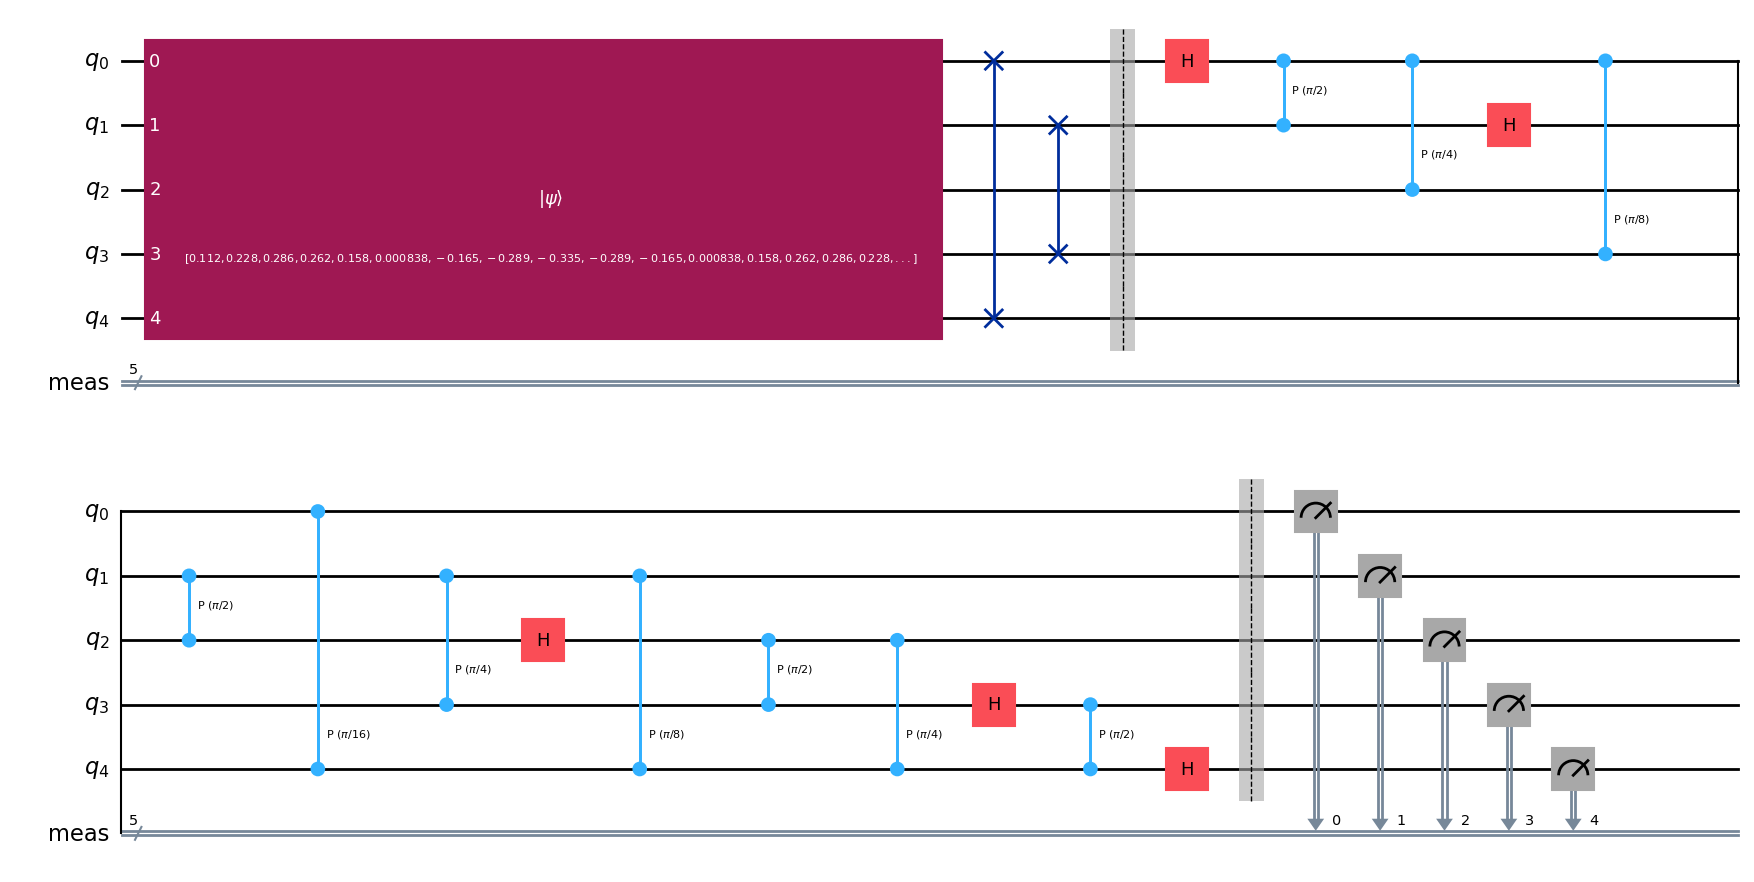

In [30]:
qft_circuit = myQFT(n_qubits)
qc = qc.compose(qft_circuit, qubits=list(range(n_qubits)))
qc.measure_all()
qc.draw('mpl')

## 5. Simulation and Results
**What happens:**
- **1024 shots** gives a better fit (generally powers of 2)
- Each shot measures all qubits, producing a 5-bit string (e.g., "00010")
- **counts** is a dictionary: {"00010": 127, "00011": 89, ...} showing how often each state was measured
- States with higher probability (larger amplitudes) appear more frequently

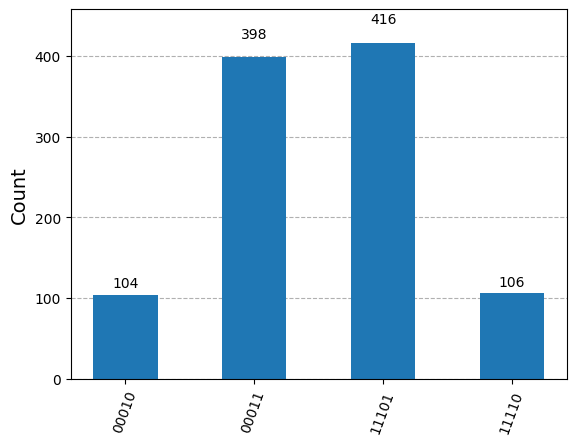

In [39]:
simulator = AerSimulator(shots=1024)
job = simulator.run(qc)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [32]:
sorted_counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
sorted_counts

{'00011': 431, '11101': 379, '00010': 114, '11110': 100}

## 5.6. Frequency Analysis
**What happens:**
- **Binary to integer conversion**: "00010" → k = 2, "00011" → k = 3
- **Frequency mapping**: The DFT produces symmetric results around N/2
  - k ∈ [0, 16] represent positive frequencies [0, 16]
  - k ∈ [17, 31] represent negative frequencies [-15, -1]
- **Probability calculation**: Converts measurement counts to normalized probabilities

In [ ]:
from fractions import Fraction

total_shots = sum(counts.values())
freqs_probs = []

for bits, c in sorted_counts.items():
    k = int(bits, 2)  # Convert binary string to integer
    if k <= N // 2:
        f = k           # Positive frequencies [0, 16]
    else:
        f = (k - N)     # Negative frequencies [-16, -1]
    p = c / total_shots # Convert counts to probabilities
    freqs_probs.append((Fraction(f'{f}/32'), p))

freqs_probs.sort(key=lambda x: x[0])
freqs_probs

[(Fraction(-3, 32), 0.3701171875),
 (Fraction(-1, 16), 0.09765625),
 (Fraction(1, 16), 0.111328125),
 (Fraction(3, 32), 0.4208984375)]

## 5.7. Expected Results

Given your input signal with frequencies 2 and 3, you should observe:
- **High counts** for bit strings "00010" (k=2) and "00011" (k=3)
- **Lower counts** for other states (due to quantum noise and finite sampling)
- **Amplitude ratio**: k=3 should have ~2x higher probability than k=2 (since 0.8 > 0.4)

## 6. For the courious ones (optional)
There is an example of how it looks like, when you place the sxap gate less approprietelz.

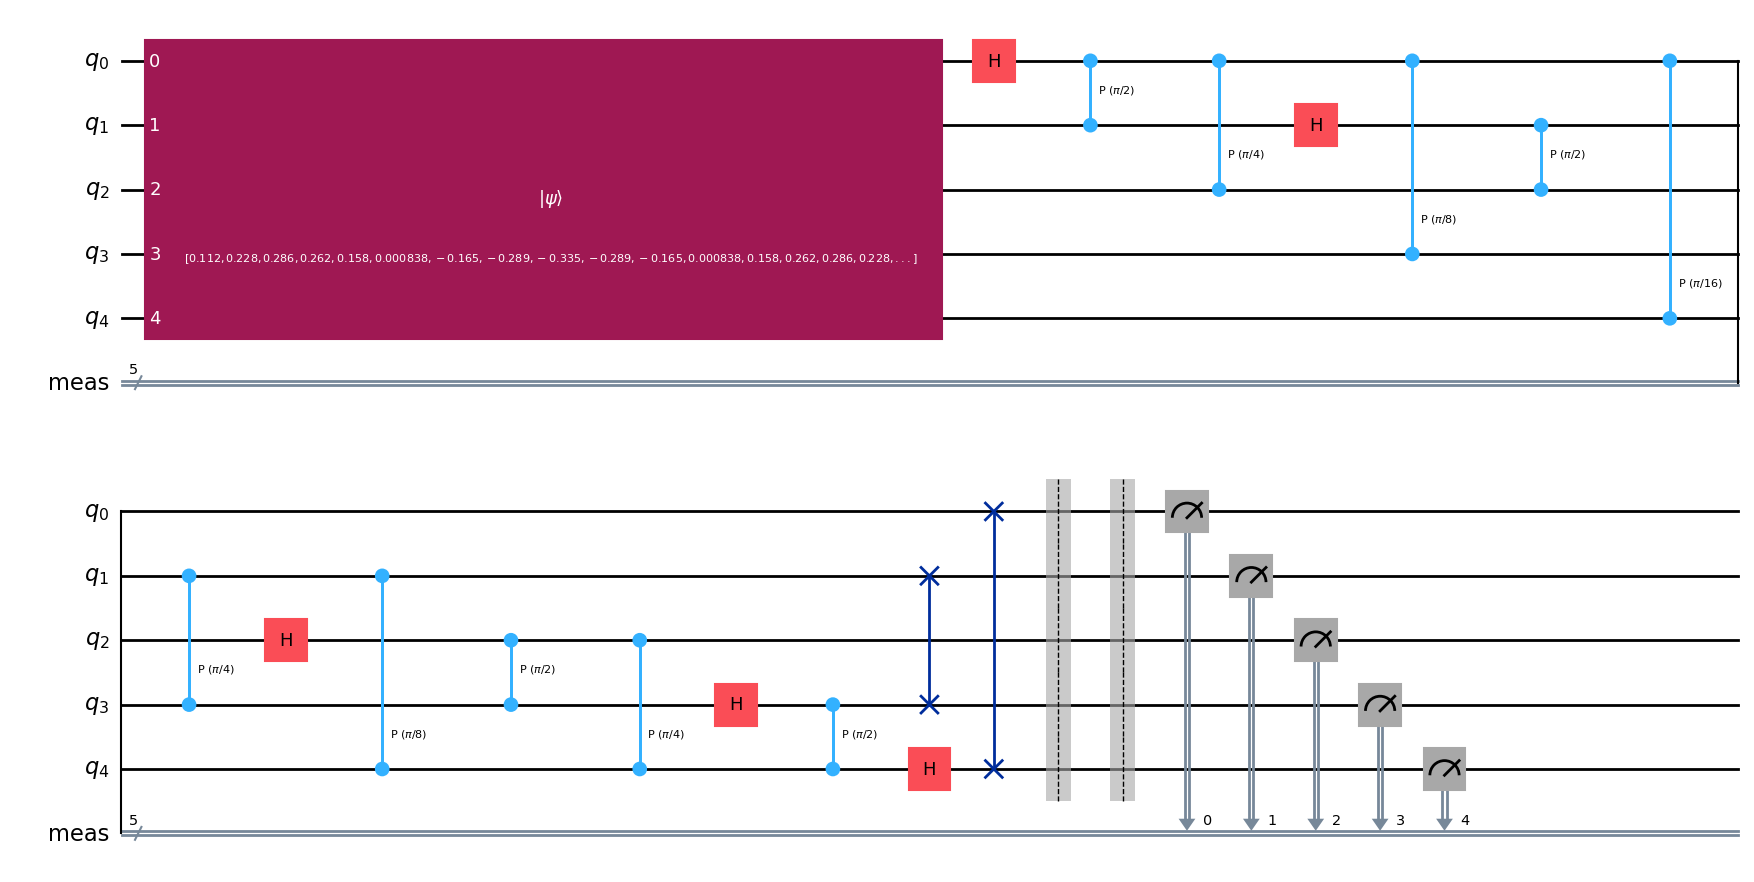

In [ ]:
def myQFT_swaps_at_the_end(n_qubits):
    circuit = QuantumCircuit(n_qubits)

    for i in range(n_qubits):
        circuit.h(i)
        for j in range(1, n_qubits - i):
            circuit.cp(pi / 2**j, i + j, i)  
    
    for j in range(n_qubits//2):
        circuit.swap(j, n_qubits-j-1)
    
    circuit.barrier()
    
    return circuit

n_qubits = int(log2(N) ) # number of qubits needed to represent N
qc2 = QuantumCircuit(n_qubits)  
qc2.initialize(a, list(range(n_qubits)))
qft_circuit2 = myQFT_swaps_at_the_end(n_qubits)
qc2 = qc2.compose(qft_circuit2, qubits=list(range(n_qubits)))
qc2.measure_all()
qc2.draw('mpl')

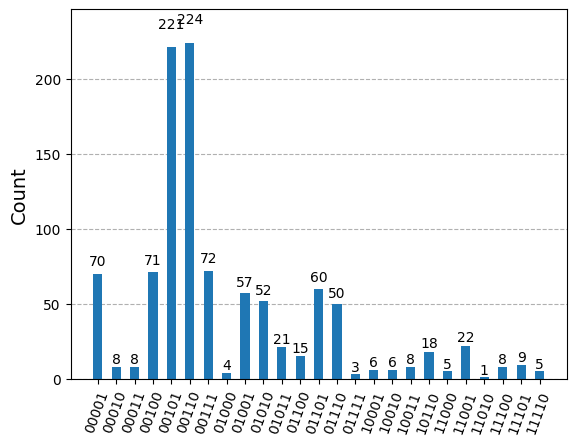

In [37]:
simulator = AerSimulator(shots=1024)
job = simulator.run(qc2)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)